<a href="https://colab.research.google.com/github/milantorandria18/Deep_Learning/blob/main/Model_RNN_Shakespeare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import the packages we need for this project

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import string
import random
import torch
import tensorflow as tf
import platform
import time
import pathlib
import os
from torchtext.data.utils import get_tokenizer

In [2]:
from torchsummary import summary

In [3]:
# Force TensorFlow to use GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else:
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


### Import the data:
The dataset called shakespeare.txt

In [5]:
cache_dir = './tmp'
dataset_file_name = 'shakespeare.txt'
dataset_file_origin = 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'

In [6]:
dataset_file_path = tf.keras.utils.get_file(
    fname = dataset_file_name,
    origin = dataset_file_origin,
    cache_dir = pathlib.Path(cache_dir).absolute()
)

In [7]:
text = open(dataset_file_path, mode ='r', encoding = 'utf-8').read()

### Analyze the data

In [12]:
#The first 50 characters in the data
print(text[:500])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


In [13]:
print("This dataset contains", len(text), "characters")

This dataset contains 1115394 characters


In [14]:
#Sampling the data
text_sample = text[:10000].split()

In [15]:
#See how the data looks like when after we split them
print(text_sample[:50])
print(len(text_sample))

['First', 'Citizen:', 'Before', 'we', 'proceed', 'any', 'further,', 'hear', 'me', 'speak.', 'All:', 'Speak,', 'speak.', 'First', 'Citizen:', 'You', 'are', 'all', 'resolved', 'rather', 'to', 'die', 'than', 'to', 'famish?', 'All:', 'Resolved.', 'resolved.', 'First', 'Citizen:', 'First,', 'you', 'know', 'Caius', 'Marcius', 'is', 'chief', 'enemy', 'to', 'the', 'people.', 'All:', 'We', "know't,", 'we', "know't.", 'First', 'Citizen:', 'Let', 'us']
1768


As we notice in the previious sample, the puctions are sticked at the end of some words. In this project, they are also important as they emphaze the style of Shakespeare with the way how he write his poem.

So we need to separate them from the words, and treat them as one of the word.

In [16]:
import string

def split_punctuation(words_list):
    result = list()

    for word in words_list:
        for char in string.punctuation:
            word = word.replace(char, " " + char + " ")
        # Supprimer les espaces en trop résultant de l'ajout de ponctuations
        word_1 = word.split()

        if (len(word_1)) == 1:
          result.append(word_1[0])
        else:
          w_1 = word_1[0]
          w_2 = word_1[1]
          result.append(w_1)
          result.append(w_2)

    return result

In [17]:
print(split_punctuation(text_sample)[:50])

['First', 'Citizen', ':', 'Before', 'we', 'proceed', 'any', 'further', ',', 'hear', 'me', 'speak', '.', 'All', ':', 'Speak', ',', 'speak', '.', 'First', 'Citizen', ':', 'You', 'are', 'all', 'resolved', 'rather', 'to', 'die', 'than', 'to', 'famish', '?', 'All', ':', 'Resolved', '.', 'resolved', '.', 'First', 'Citizen', ':', 'First', ',', 'you', 'know', 'Caius', 'Marcius', 'is', 'chief']


In [18]:
#Apply the function in the whole dataset
text_split = split_punctuation(text.split())
print(len(text_split))
text_list = list(set(text_split))
print(len(text_list))

254793
13152


In [19]:
print(text_split[:10])
print(sorted(text_list))

['First', 'Citizen', ':', 'Before', 'we', 'proceed', 'any', 'further', ',', 'hear']
['!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'ABHORSON', 'ABRAHAM', 'ADRIAN', 'AEacides', 'AEdile', 'AEdiles', 'AEneas', 'AEsop', 'ALL', 'ALONSO', 'ANGELO', 'ANNE', 'ANOTHER', 'ANTIGONUS', 'ANTONIO', 'ARCHBISHOP', 'ARCHIDAMUS', 'ARIEL', 'AUFIDIUS', 'AUMERLE', 'AUTOLYCUS', 'Abase', 'Abate', 'Abated', 'Abbot', 'Abel', 'Abhorred', 'Abhorson', 'Abides', 'Able', 'About', 'Above', 'Abraham', 'Absolute', 'Accept', 'Accomplish', 'According', 'Accords', 'Account', 'Accountant', 'Accursed', 'Accuse', 'Achieve', 'Acquaint', 'Action', 'Adam', 'Add', 'Added', 'Adding', 'Address', 'Adieu', 'Adjudged', 'Admit', 'Adonis', 'Adoptedly', 'Adopts', 'Adrian', 'Adriatic', 'Advance', 'Advantaging', 'Adversity', 'Advertising', 'Advocate', 'Affection', 'Affliction', 'Affrighted', 'Affrights', 'Affront', 'Afore', 'Afresh', 'Afric', 'African', 'After', 'Again', 'Against', 'Agamemnon', 'Age', 'Aged', 'Agenor', 'Agr

In [20]:
trigrams = [([text_split[i], text_split[i + 1]], text_split[i + 2])
            for i in range(len(text_split) - 2)]
chunk_len=len(trigrams)
print(trigrams[:30])
print(chunk_len)

[(['First', 'Citizen'], ':'), (['Citizen', ':'], 'Before'), ([':', 'Before'], 'we'), (['Before', 'we'], 'proceed'), (['we', 'proceed'], 'any'), (['proceed', 'any'], 'further'), (['any', 'further'], ','), (['further', ','], 'hear'), ([',', 'hear'], 'me'), (['hear', 'me'], 'speak'), (['me', 'speak'], '.'), (['speak', '.'], 'All'), (['.', 'All'], ':'), (['All', ':'], 'Speak'), ([':', 'Speak'], ','), (['Speak', ','], 'speak'), ([',', 'speak'], '.'), (['speak', '.'], 'First'), (['.', 'First'], 'Citizen'), (['First', 'Citizen'], ':'), (['Citizen', ':'], 'You'), ([':', 'You'], 'are'), (['You', 'are'], 'all'), (['are', 'all'], 'resolved'), (['all', 'resolved'], 'rather'), (['resolved', 'rather'], 'to'), (['rather', 'to'], 'die'), (['to', 'die'], 'than'), (['die', 'than'], 'to'), (['than', 'to'], 'famish')]
254791


In [21]:
#For the rest of the analysis, we only use 25'000 rows (1/10 of the data)
trigrams = trigrams[:150000]
chunk_len=len(trigrams)

In [22]:
#Create a dictionary which give every single word an index, that we will use in the data set
vocab = set(text_split)
voc_len=len(vocab)
word_to_ix = {word: i for i, word in enumerate(vocab)}

In [23]:
print(word_to_ix)

{'fatigate': 0, 'fastest': 1, 'Cretan': 2, 'Anon': 3, 'hang': 4, 'Fame': 5, 'abundantly': 6, 'shallow': 7, 'Flavius': 8, 'quench': 9, 'father': 10, 'foemen': 11, 'tumble': 12, 'mind': 13, 'wither': 14, 'Outlive': 15, 'perverse': 16, 'impart': 17, 'tyrant': 18, 'heating': 19, 'worshipful': 20, 'breathes': 21, 'Neighbours': 22, 'lampass': 23, 'interpretation': 24, 'manage': 25, 'troll': 26, 'salter': 27, 'resist': 28, 'skulls': 29, 'Triton': 30, 'declines': 31, 'factious': 32, 'aided': 33, 'Fit': 34, 'Redime': 35, 'requiring': 36, 'Traitor': 37, '?': 38, 'unmoan': 39, 'boy': 40, 'pricked': 41, 'alms': 42, ';': 43, 'Lives': 44, 'humorous': 45, 'true': 46, 'sparing': 47, 'deed': 48, 'hills': 49, 'jour': 50, 'consulship': 51, 'securely': 52, 'forted': 53, 'widows': 54, 'Hector': 55, 'defiance': 56, 'upstart': 57, 'penalties': 58, 'lamenting': 59, 'redress': 60, 'penalty': 61, 'lightnings': 62, 'Yet': 63, 'misfortune': 64, 'marchpane': 65, 'bug': 66, 'preachment': 67, 'pearl': 68, 'ninescore

In [24]:
#Convert the word into number based on the index
inp=[]
tar=[]
for context, target in trigrams:
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)
        inp.append(context_idxs)
        targ = torch.tensor([word_to_ix[target]], dtype=torch.long)
        tar.append(targ)

In [25]:
print(len(inp))
print(inp[:20])

150000
[tensor([6479, 5360]), tensor([5360, 6338]), tensor([6338,  988]), tensor([ 988, 2013]), tensor([2013, 5418]), tensor([5418, 4045]), tensor([4045, 9739]), tensor([9739, 9473]), tensor([9473, 9735]), tensor([9735, 5366]), tensor([5366, 7977]), tensor([7977,  481]), tensor([ 481, 7350]), tensor([7350, 6338]), tensor([6338, 8489]), tensor([8489, 9473]), tensor([9473, 7977]), tensor([7977,  481]), tensor([ 481, 6479]), tensor([6479, 5360])]


In [26]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size*2, hidden_size, n_layers,batch_first=True,
                          bidirectional=False)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [27]:
def train(inp, target):
    hidden = decoder.init_hidden().cuda()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c].cuda(), hidden)
        loss += criterion(output, target[c].cuda())

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

In [28]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [30]:
n_epochs = 30
print_every = 1
plot_every = 1
hidden_size = 100
n_layers = 1
lr = 0.015

decoder = RNN(voc_len, hidden_size, voc_len, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0
if(train_on_gpu):
    decoder.cuda()
for epoch in range(1, n_epochs + 1):
    loss = train(inp,tar)
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs *100 , loss))
#         print(evaluate('ge', 200), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 17s (1 3%) 9.5095]
 35s (2 6%) 9.1061]
 55s (3 10%) 7.9348]
 13s (4 13%) 6.9032]
 31s (5 16%) 6.4921]
 48s (6 20%) 6.3796]
 7s (7 23%) 6.3181]
 26s (8 26%) 6.2675]
 44s (9 30%) 6.1649]
 0s (10 33%) 6.0389]
 17s (11 36%) 5.9426]
 36s (12 40%) 5.8751]
 53s (13 43%) 5.8166]
 11s (14 46%) 5.7539]
 28s (15 50%) 5.6843]
 45s (16 53%) 5.6115]
 2s (17 56%) 5.5416]
 19s (18 60%) 5.4776]
 37s (19 63%) 5.4187]
 54s (20 66%) 5.3612]
 14s (21 70%) 5.3031]
 37s (22 73%) 5.2450]
 0s (23 76%) 5.1887]
 21s (24 80%) 5.1345]
 38s (25 83%) 5.0822]
 55s (26 86%) 5.0304]
 12s (27 90%) 4.9786]
 31s (28 93%) 4.9273]
 48s (29 96%) 4.8776]
 5s (30 100%) 4.8295]


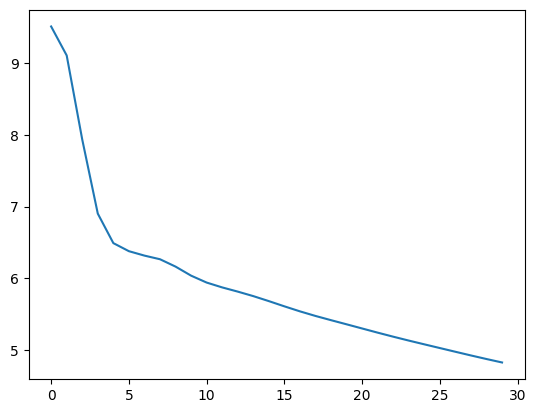

In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [32]:
def evaluate(prime_str='we speak', predict_len=100, temperature=1):
    hidden = decoder.init_hidden().cuda()

    for p in range(predict_len):

        prime_input = torch.tensor([word_to_ix[w] for w in prime_str.split()], dtype=torch.long).cuda()
        inp = prime_input[-2:] #last two words as input
        output, hidden = decoder(inp, hidden)

        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted word to string and use as next input
        predicted_word = list(word_to_ix.keys())[list(word_to_ix.values()).index(top_i)]
        prime_str += " " + predicted_word
#         inp = torch.tensor(word_to_ix[predicted_word], dtype=torch.long)

    return prime_str

In [33]:
print(evaluate('you speak', 100, temperature=1.2))

you speak haste make shed entombed unto case . MERCUTIO : I faint keeping sweet , for we are flow gentleman ' boot , doth each counsel more senators of Exeter to pity against our state Coriolanus Put now tears to loving the bier Edward man do King party , underneath from the Pluto bats good smiles . SICINIUS : Tut , Withal Lovers To hold Friar prince that babe visits he join muster back beats ! knighthood more malice This stay you cast were impeach ' human taught did honour My hearts , prosperity soul religious kings without blind ! wear


In [34]:
print(evaluate('you speak', 100, temperature=0.5))

you speak sits to get our solemnity frantic swift sepulchre ! O , I am not , I am not , when I have been more . KING EDWARD IV : Why , and you , but by the man of yours . MENENIUS : I will be ruled of the day . : I am the gods of the world : I do beseech , my lord , and this : the mayor of York . GLOUCESTER : Go , I have done to my grave , And it , and the way to this presence ' , in his eyes


In [35]:
print(evaluate('ROMEO :', 100, temperature=1.2))

ROMEO : urge gi go . ROMEO : Nay reach there sight and your brethren night before familiar grave repose them ? of the world . Richard muniments is ready ? So merit Selves thyself ! brake guilty chafed in extremity soon watching . DERBY say come ! or but Death as we desire clapping warriors he shall carry native , The life were banishment , a blood That o did forsake and till ' and thee : and awry thy throne together : and back empoison with the east next from nature dissolute where Why modest ? marry but ' you
